<h1 style="text-align: center; font-family: 'Lucida Handwriting', cursive; font-weight: bold; font-size: 48px; color: #8e44ad;">Brain Tumor Detection</h1>

<div style="border: 2px solid #ccc; border-radius: 15px; padding: 15px; margin-bottom: 20px; background-color: #f7e4e4; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
  <h3 style="color:#d62828;">Glioma Tumor</h3>
  <p><strong>Description:</strong> Gliomas are common tumors in the brain and spinal cord, arising from glial cells. They can vary from benign to aggressive forms and are a leading cause of primary brain tumors.</p>
</div>

<div style="border: 2px solid #ccc; border-radius: 15px; padding: 15px; margin-bottom: 20px; background-color: #e6f7e6; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
  <h3 style="color:#1b5e20;">Meningioma Tumor</h3>
  <p><strong>Description:</strong> Meningiomas originate from the meninges, the brain’s protective layers. Most are benign, but some may be atypical or malignant. They are slow-growing and often found incidentally.</p>
</div>

<div style="border: 2px solid #ccc; border-radius: 15px; padding: 15px; margin-bottom: 20px; background-color: #e4e7f7; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
  <h3 style="color:#2a52be;">Normal</h3>
  <p><strong>Description:</strong> This class consists of MRI images of healthy brain tissue, without any tumors. These control images help the model differentiate between healthy and abnormal cases.</p>
</div>

<div style="border: 2px solid #ccc; border-radius: 15px; padding: 15px; margin-bottom: 20px; background-color: #f7f4e4; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
  <h3 style="color:#e68a00;">Pituitary Tumor</h3>
  <p><strong>Description:</strong> Pituitary tumors occur in the pituitary gland, which controls hormone production. These tumors are typically benign but may affect the body's hormone balance.</p>
</div>


<h1 style="text-align: left; font-family: Arial, sans-serif; font-weight: bold; font-size: 36px; color: #3498db;">Import Some Important Libraries:</h1>

In [67]:
import matplotlib.pyplot as plt
import random
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary

<h1 style="text-align: left; font-family: Arial, sans-serif; font-weight: bold; font-size: 36px; color: #3498db;">Load data:</h1>

In [68]:
data_path = '/kaggle/input/brain-tumors-256x256/Data'

In [69]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [70]:
dataset = datasets.ImageFolder(data_path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [71]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


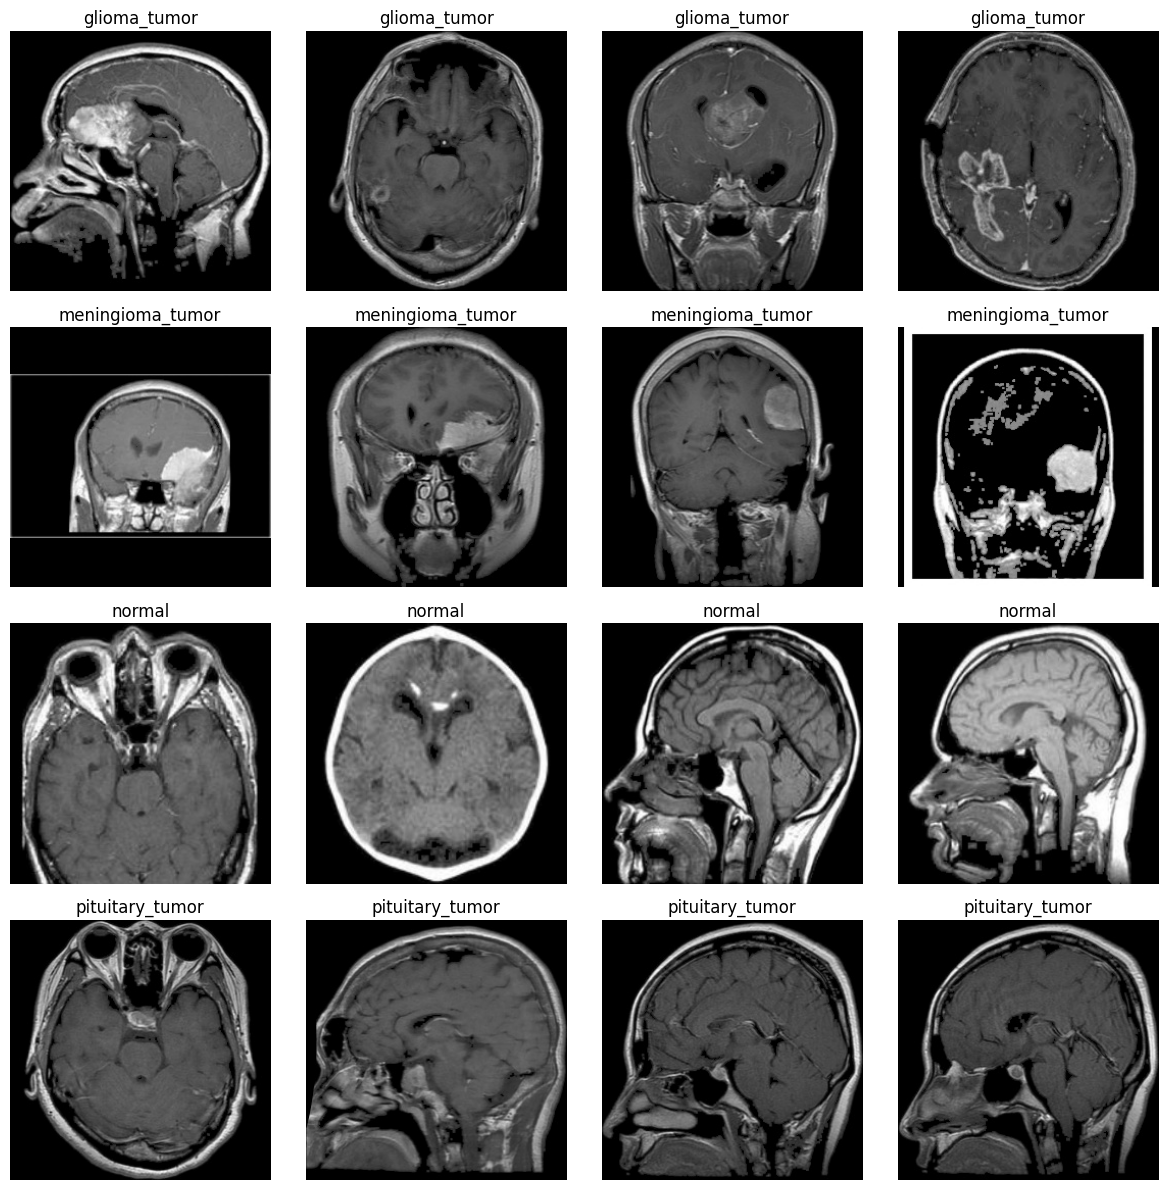

In [72]:

def show_images(dataset, num_images=4):
    classes = dataset.classes
    images_per_class = {cls: [] for cls in classes}

    for img, label in dataset:
        cls_name = classes[label]
        if len(images_per_class[cls_name]) < num_images:
            images_per_class[cls_name].append(img)
        
        if all(len(images) >= num_images for images in images_per_class.values()):
            break

    
    fig, axes = plt.subplots(len(classes), num_images, figsize=(12, 12))
    for row_idx, cls_name in enumerate(classes):
        for img_idx in range(num_images):
            axes[row_idx, img_idx].imshow(images_per_class[cls_name][img_idx].permute(1, 2, 0))  
            axes[row_idx, img_idx].axis('off')
            
            axes[row_idx, img_idx].set_title(f"{cls_name}", fontsize=12, pad=5)

    plt.tight_layout()
    plt.show()


show_images(dataset)




<h1 style="text-align: left; font-family: Arial, sans-serif; font-weight: bold; font-size: 36px; color: #3498db;">CNN model:</h1>

In [73]:

class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()

        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=1, padding=0)  
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)  

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=0)  
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)  

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=0)  
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=1, padding=0)  
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  

        
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 4)  

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.pool4(self.relu(self.conv4(x)))
        
        x = self.flatten(x)  
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x



In [74]:
model = BrainTumorCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [75]:

summary(model, (3, 256, 256)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 253, 253]           1,568
              ReLU-2         [-1, 32, 253, 253]               0
         MaxPool2d-3           [-1, 32, 84, 84]               0
            Conv2d-4           [-1, 64, 81, 81]          32,832
              ReLU-5           [-1, 64, 81, 81]               0
         MaxPool2d-6           [-1, 64, 40, 40]               0
            Conv2d-7          [-1, 128, 37, 37]         131,200
              ReLU-8          [-1, 128, 37, 37]               0
         MaxPool2d-9          [-1, 128, 18, 18]               0
           Conv2d-10          [-1, 256, 15, 15]         524,544
             ReLU-11          [-1, 256, 15, 15]               0
        MaxPool2d-12            [-1, 256, 7, 7]               0
          Flatten-13                [-1, 12544]               0
           Linear-14                  [

<h1 style="text-align: left; font-family: Arial, sans-serif; font-weight: bold; font-size: 36px; color: #3498db;">Training the Model:</h1>

In [76]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, early_stopping_patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        
        model.eval()  
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        
        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        
        print(f'Epoch {epoch + 1}/{num_epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}% - '
              f'Eval Loss: {val_loss:.4f}, Eval Accuracy: {100 * val_accuracy:.2f}%')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')  
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Call the training function
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10 - Train Loss: 1.2738, Train Accuracy: 36.31% - Eval Loss: 1.1090, Eval Accuracy: 43.04%
Epoch 2/10 - Train Loss: 1.0394, Train Accuracy: 54.56% - Eval Loss: 0.9038, Eval Accuracy: 62.14%
Epoch 3/10 - Train Loss: 0.8681, Train Accuracy: 65.19% - Eval Loss: 0.8360, Eval Accuracy: 65.37%
Epoch 4/10 - Train Loss: 0.7021, Train Accuracy: 72.33% - Eval Loss: 0.7143, Eval Accuracy: 70.55%
Epoch 5/10 - Train Loss: 0.5655, Train Accuracy: 78.84% - Eval Loss: 0.6955, Eval Accuracy: 72.49%
Epoch 6/10 - Train Loss: 0.4598, Train Accuracy: 82.92% - Eval Loss: 0.4569, Eval Accuracy: 81.88%
Epoch 7/10 - Train Loss: 0.3519, Train Accuracy: 87.20% - Eval Loss: 0.4198, Eval Accuracy: 84.47%
Epoch 8/10 - Train Loss: 0.2188, Train Accuracy: 91.96% - Eval Loss: 0.4155, Eval Accuracy: 86.73%
Epoch 9/10 - Train Loss: 0.1839, Train Accuracy: 93.09% - Eval Loss: 0.4418, Eval Accuracy: 86.73%
Epoch 10/10 - Train Loss: 0.1241, Train Accuracy: 95.56% - Eval Loss: 0.5400, Eval Accuracy: 84.79%


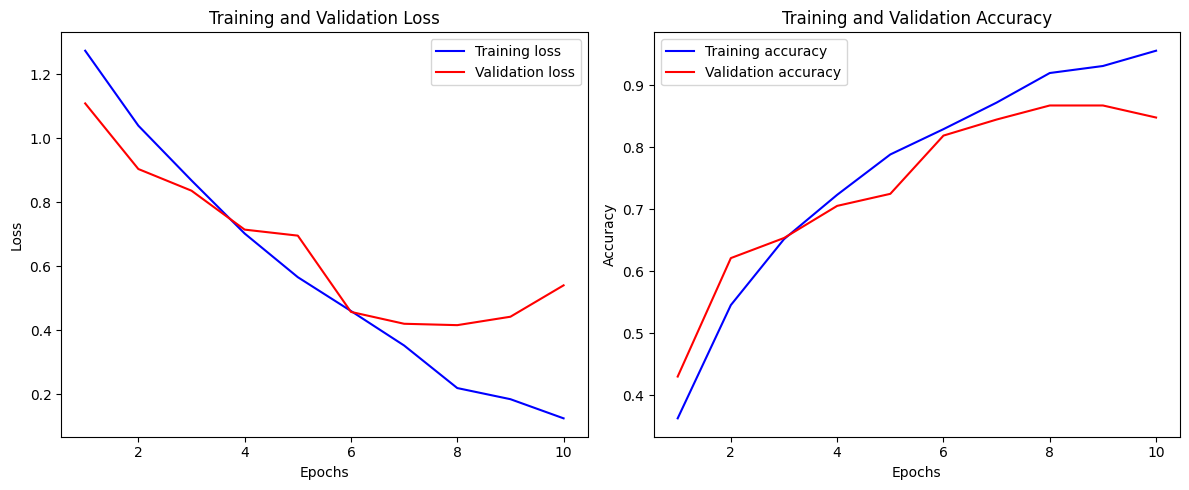

In [79]:


def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


<h1 style="text-align: left; font-family: Arial, sans-serif; font-weight: bold; font-size: 36px; color: #3498db;">Evaluation:</h1>

In [80]:
model.eval()  
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


Accuracy: 87.46%


<h1 style="text-align: left; font-family: Arial, sans-serif; font-weight: bold; font-size: 36px; color: #3498db;">Visualize Results:</h1>

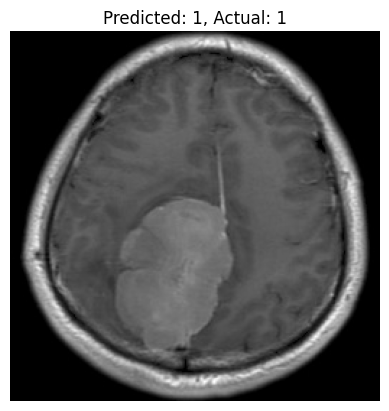

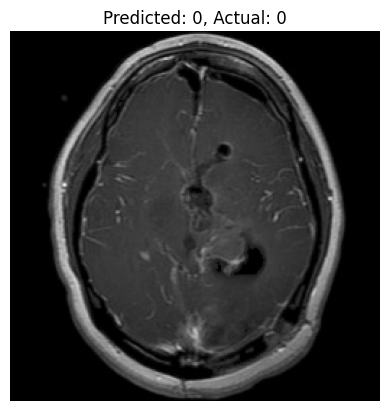

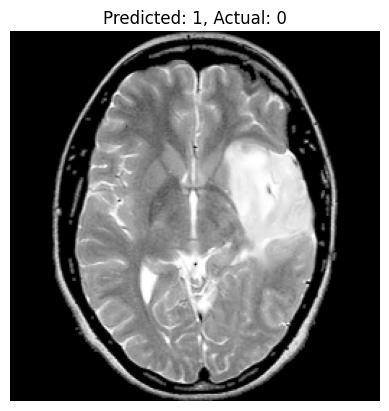

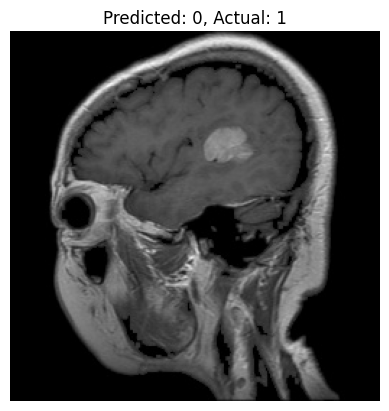

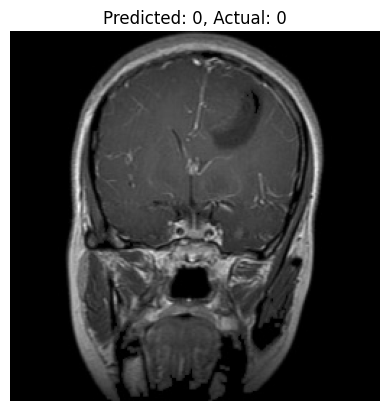

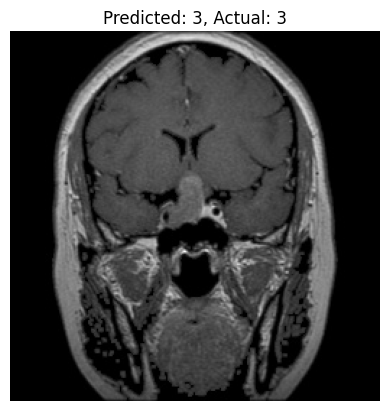

In [85]:


def imshow(image, title):
    
    image = image.numpy().transpose((1, 2, 0))  
    image = (image - image.min()) / (image.max() - image.min())  
    plt.imshow(image)  
    plt.title(title)
    plt.axis('off')  
    plt.show()


dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

for i in range(6):
    imshow(images[i], f'Predicted: {predicted[i]}, Actual: {labels[i]}')

<h1 style="text-align: left; font-family: Arial, sans-serif; font-weight: bold; font-size: 36px; color: #3498db;">Save the Model:</h1>

In [86]:
torch.save(model.state_dict(), 'brain_tumor_model.pth')
